## HHL by Qrisp for solving linear system of equations

In [1]:
import jax
import qrisp

In [2]:
def QPE(psi, U, precision=None, res=None):

    if res is None:
        res = qrisp.QuantumFloat(precision, -precision)

    qrisp.h(res)

    # Performs a loop with a dynamic bound in Jasp mode.
    for i in qrisp.jrange(res.size):
        with qrisp.control(res[i]):
            for j in qrisp.jrange(2**i):
                U(psi)

    return qrisp.QFT(res, inv=True)

In [3]:
import numpy as np

def U(psi):
    phi_1 = 0.5
    phi_2 = 0.125

    qrisp.p(phi_1 * 2 * np.pi, psi[0])  # p applies a phase gate
    qrisp.p(phi_2 * 2 * np.pi, psi[1])

psi = qrisp.QuantumFloat(2)
qrisp.h(psi)

res = QPE(psi, U, precision=3)

In [4]:
print(qrisp.multi_measurement([psi, res]))

{(0, 0.0): 0.25, (1, 0.5): 0.25, (2, 0.125): 0.25, (3, 0.625): 0.25}                 


In [5]:
@qrisp.terminal_sampling
def main():
    qf = qrisp.QuantumFloat(2)
    qf[:] = 3

    res = QPE(qf, U, precision=3)

    return res

main()

{0.625: 1.0}

## The HHL algorithm

In [6]:
def fake_inversion(qf, res=None):

    if res is None:
        res = qrisp.QuantumFloat(qf.size + 1)

    for i in qrisp.jrange(qf.size):
        qrisp.cx(qf[i], res[qf.size - i])

    return res

In [7]:
qf = qrisp.QuantumFloat(3, -3)
qrisp.x(qf[2])
qrisp.dicke_state(qf, 1)
res = fake_inversion(qf)
print(qrisp.multi_measurement([qf, res]))

{(0.125, 8): 0.3333333333333333, (0.25, 4): 0.3333333333333333, (0.5, 2): 0.3333333333333333}


In [8]:
@qrisp.RUS(static_argnums=[0, 1])
def HHL_encoding(b, hamiltonian_evolution, n, precision):

    # Prepare the state |b>. Step 1
    qf = qrisp.QuantumFloat(n)
    # Reverse the endianness for compatibility with Hamiltonian simulation.
    qrisp.prepare(qf, b, reversed=True)

    qpe_res = QPE(qf, hamiltonian_evolution, precision=precision)  # Step 2
    inv_res = fake_inversion(qpe_res)  # Step 3

    case_indicator = qrisp.QuantumFloat(inv_res.size)

    with qrisp.conjugate(qrisp.h)(case_indicator):
        qbl = (case_indicator >= inv_res)

    cancellation_bool = (qrisp.measure(case_indicator) == 0) & (qrisp.measure(qbl) == 0)

    # The first return value is a boolean value. Additional return values are QuantumVariables.
    return cancellation_bool, qf, qpe_res, inv_res

In [9]:
def HHL(b, hamiltonian_evolution, n, precision):

    qf, qpe_res, inv_res = HHL_encoding(b, hamiltonian_evolution, n, precision)

    # Uncompute qpe_res and inv_res
    with qrisp.invert():
        QPE(qf, hamiltonian_evolution, res=qpe_res)
        fake_inversion(qpe_res, res=inv_res)

    # Reverse the endianness for compatibility with Hamiltonian simulation.
    for i in qrisp.jrange(qf.size // 2):
        qrisp.swap(qf[i], qf[n - i - 1])

    return qf

In [10]:
from qrisp.operators import QubitOperator
import numpy as np

A = np.array([[3 / 8, 1 / 8], [1 / 8, 3 / 8]])
b = np.array([1, 1])

H = QubitOperator.from_matrix(A).to_pauli()


# By default e^{-itH} is performed. Therefore, we set t=-pi.
def U(qf):
    H.trotterization()(qf, t=-np.pi, steps=1)

In [11]:
@qrisp.terminal_sampling
def main():
    x = HHL(tuple(b), U, 1, 3)
    return x


res_dict = main()

for k, v in res_dict.items():
    res_dict[k] = v**0.5

print(res_dict)

Simulating 1 qubits.. |                                                      | [  0%]

{0.0: 0.7071068022600167, 1.0: 0.7071067601130777}                                   


In [12]:
x = (np.linalg.inv(A) @ b) / np.linalg.norm(np.linalg.inv(A) @ b)
print(x)

[0.70710678 0.70710678]


## Advanced example

In [13]:
def hermitian_matrix_with_power_of_2_eigenvalues(n):
    # Generate eigenvalues as inverse powers of 2.
    eigenvalues = 1 / np.exp2(np.random.randint(1, 4, size=n))

    # Generate a random unitary matrix.
    Q, _ = np.linalg.qr(np.random.randn(n, n))

    # Construct the Hermitian matrix.
    A = Q @ np.diag(eigenvalues) @ Q.conj().T

    return A


# Example
n = 3
A = hermitian_matrix_with_power_of_2_eigenvalues(2**n)

H = QubitOperator.from_matrix(A).to_pauli()


def U(qf):
    H.trotterization()(qf, t=-np.pi, steps=5)


b = np.random.randint(0, 2, size=2**n)

print("Hermitian matrix A:")
print(A)

print("Eigenvalues:")
print(np.linalg.eigvals(A))

print("b:")
print(b)

Hermitian matrix A:
[[ 0.17579138 -0.0152622  -0.01617484  0.02232296  0.04269751  0.08323922
   0.01624733  0.04489905]
 [-0.0152622   0.22703081  0.0214731   0.00493727 -0.02837213 -0.00087943
   0.00881697  0.0318943 ]
 [-0.01617484  0.0214731   0.18005377  0.05823654  0.01611289 -0.08820297
  -0.00063391  0.01997325]
 [ 0.02232296  0.00493727  0.05823654  0.30964127  0.05773026  0.01905031
  -0.06665161  0.07976392]
 [ 0.04269751 -0.02837213  0.01611289  0.05773026  0.19888827 -0.00341997
  -0.01443905  0.08619575]
 [ 0.08323922 -0.00087943 -0.08820297  0.01905031 -0.00341997  0.44944918
   0.01656659 -0.00167413]
 [ 0.01624733  0.00881697 -0.00063391 -0.06665161 -0.01443905  0.01656659
   0.2695831  -0.08096163]
 [ 0.04489905  0.0318943   0.01997325  0.07976392  0.08619575 -0.00167413
  -0.08096163  0.31456221]]
Eigenvalues:
[0.125 0.25  0.5   0.5   0.125 0.125 0.25  0.25 ]
b:
[0 1 0 1 0 1 1 1]


In [14]:
@qrisp.terminal_sampling
def main():
    x = HHL(tuple(b), U, n, 4)
    return x

res_dict = main()

for k, v in res_dict.items():
    res_dict[k] = v**0.5

computed = np.array([res_dict[key] for key in sorted(res_dict)])

In [15]:
print(computed)

[0.2699076  0.34497583 0.1230823  0.40673639 0.14374125 0.22348805
 0.60397114 0.43836997]


In [16]:
x = (np.linalg.inv(A) @ b) / np.linalg.norm(np.linalg.inv(A) @ b)
print(x)

[-0.2709178   0.34487552 -0.12211068  0.40642685 -0.14290287  0.22149382
  0.60502874  0.43821239]


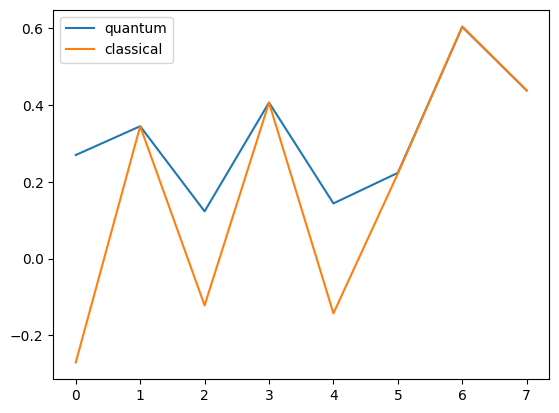

In [17]:
import matplotlib.pyplot as plt

plt.plot(computed, label='quantum')
plt.plot(x, label='classical')
plt.legend()
plt.show()

## My example

In [18]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.linalg import inv, norm

n = 3 # number of qubits, num_qubits
N = pow(2,n) # number of mesh nodes

# T_old
T_old = np.ones(N)
for i in range(N):
    T_old[i] = 1 + (1/2)*np.sin(2*np.pi*(i+1)/N)
print(T_old)

# Linear system C*T_new = T_old
# T_new = inv(C)*T_old
r = 0.5 # = delta_t*alpha/(delta_x**2) = Fo, Fourier number 
d = np.ones(N)*(1+2*r)
od = np.ones(N-1)*(-r)
C = np.diag(d, 0) + np.diag(od, -1) + np.diag(od, 1)
C[0,N-1] = -r
C[N-1,0] = -r
print(C)

# T_new
T_new = inv(C) @ T_old
print(T_new)

[1.35355339 1.5        1.35355339 1.         0.64644661 0.5
 0.64644661 1.        ]
[[ 2.  -0.5  0.   0.   0.   0.   0.  -0.5]
 [-0.5  2.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.  -0.5  2.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.  -0.5  2.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.  -0.5  2.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.  -0.5  2.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.  -0.5  2.  -0.5]
 [-0.5  0.   0.   0.   0.   0.  -0.5  2. ]]
[1.27345908 1.38672954 1.27345908 1.         0.72654092 0.61327046
 0.72654092 1.        ]


In [19]:
# T_old
TT_old = np.sum(T_old**2)
b0 = np.sqrt(TT_old)
print(b0)
b = T_old/b0
print(b)
print(sum(b**2)) # (normalized)

# T_new
TT_new = np.sum(T_new**2)
x0 = np.sqrt(TT_new)
x_th = T_new/x0 # (theoretical)
print(x_th)
print(sum(x_th**2)) # (normalized)

# Linear system (normalized)
f = np.sqrt(TT_new/TT_old) 
A = C*f # (normalized)

# Check
print(b * b0 - T_old) # normalized linear system
print(x_th * x0 - T_new) # back to original units
print(C @ T_new - T_old) # original system
print( A @ x_th - b ) # normalized system for quantum computing

3.0
[0.45118446 0.5        0.45118446 0.33333333 0.2154822  0.16666667
 0.2154822  0.33333333]
1.0
[0.43429041 0.47291927 0.43429041 0.34103209 0.24777377 0.20914491
 0.24777377 0.34103209]
0.9999999999999999
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.11022302e-16]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-6.66133815e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
 -2.22044605e-16 -1.11022302e-16  1.11022302e-16 -1.11022302e-16]
[-2.77555756e-16  1.11022302e-16 -5.55111512e-17  1.11022302e-16
 -5.55111512e-17 -5.55111512e-17 -2.77555756e-17 -5.55111512e-17]


In [20]:
H = QubitOperator.from_matrix(A).to_pauli()

def U(qf):
    H.trotterization()(qf, t=-np.pi, steps=5)

print("Hermitian matrix A:")
print(A)

print("Eigenvalues:")
print(np.linalg.eigvals(A))

print("b:")
print(b)

Hermitian matrix A:
[[ 1.95485026 -0.48871256  0.          0.          0.          0.
   0.         -0.48871256]
 [-0.48871256  1.95485026 -0.48871256  0.          0.          0.
   0.          0.        ]
 [ 0.         -0.48871256  1.95485026 -0.48871256  0.          0.
   0.          0.        ]
 [ 0.          0.         -0.48871256  1.95485026 -0.48871256  0.
   0.          0.        ]
 [ 0.          0.          0.         -0.48871256  1.95485026 -0.48871256
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.48871256  1.95485026
  -0.48871256  0.        ]
 [ 0.          0.          0.          0.          0.         -0.48871256
   1.95485026 -0.48871256]
 [-0.48871256  0.          0.          0.          0.          0.
  -0.48871256  1.95485026]]
Eigenvalues:
[2.93227539 2.6459942  1.95485026 0.97742513 1.26370632 2.6459942
 1.95485026 1.26370632]
b:
[0.45118446 0.5        0.45118446 0.33333333 0.2154822  0.16666667
 0.2154822  0.33333333]


In [21]:
@qrisp.terminal_sampling
def main():
    x = HHL(tuple(b), U, n, 8)
    return x

res_dict = main()

for k, v in res_dict.items():
    res_dict[k] = v**0.5

computed = np.array([res_dict[key] for key in sorted(res_dict)])

In [22]:
import statistics

x_mean = statistics.mean(computed)
T_mean = statistics.mean(T_old)
scale = T_mean/x_mean
T_new_q = computed*scale

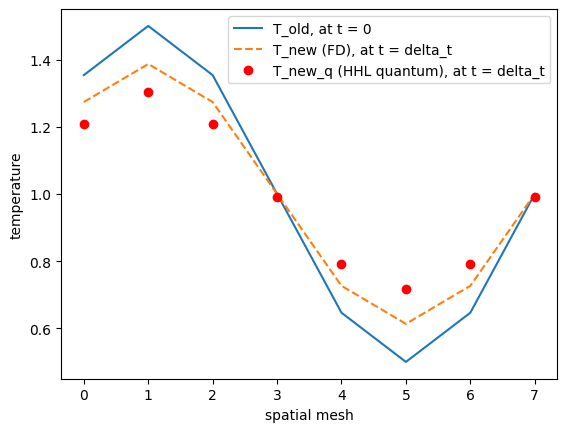

In [23]:
plt.plot(T_old, label='T_old, at t = 0')
plt.plot(T_new, label='T_new (FD), at t = delta_t', linestyle='dashed')
plt.plot(T_new_q, 'ro', label='T_new_q (HHL quantum), at t = delta_t')
plt.legend()
plt.xlabel('spatial mesh')
plt.ylabel('temperature')
plt.show()